In [1]:
# Standard library imports
import csv
import itertools
import os
import os.path
import random
from glob import glob
from pathlib import Path
import zlib
import importlib

# Third-party imports
import cv2
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import skimage
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from skimage.transform import resize
from sklearn import model_selection
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import (KFold, StratifiedKFold, cross_val_score,
                                     learning_curve, train_test_split)
from sklearn.utils import class_weight, shuffle
from tqdm import tqdm

# Keras-specific imports
import keras
from keras import backend as K
from keras import layers, models, optimizers
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import (Activation, AveragePooling2D, BatchNormalization,
                          Conv2D, Dense, Dropout, Flatten, Lambda, MaxPool2D,
                          MaxPooling2D)
from keras.models import Model, Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.utils import to_categorical

# Custom imports
import fit
import evaluate
import viz

%matplotlib inline

In [4]:
imageSize=50
train_dir = "/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/archive/asl_alphabet_train/asl_alphabet_train"
test_dir =  "/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/archive/asl_alphabet_test/asl_alphabet_test"

def get_data(folder):
    # Load data and labels from parent folder
    X = []
    y = []
    for folderName in os.listdir(folder):
        full_path = os.path.join(folder, folderName)  # Create full path to the item
        if os.path.isdir(full_path):  # Check if the item is a directory
            if not folderName.startswith('.'):
                if folderName in ['A']:
                    label = 0
                elif folderName in ['B']:
                    label = 1
                elif folderName in ['C']:
                    label = 2
                elif folderName in ['D']:
                    label = 3
                elif folderName in ['E']:
                    label = 4
                elif folderName in ['F']:
                    label = 5
                elif folderName in ['G']:
                    label = 6
                elif folderName in ['H']:
                    label = 7
                elif folderName in ['I']:
                    label = 8
                elif folderName in ['J']:
                    label = 9
                elif folderName in ['K']:
                    label = 10
                elif folderName in ['L']:
                    label = 11
                elif folderName in ['M']:
                    label = 12
                elif folderName in ['N']:
                    label = 13
                elif folderName in ['O']:
                    label = 14
                elif folderName in ['P']:
                    label = 15
                elif folderName in ['Q']:
                    label = 16
                elif folderName in ['R']:
                    label = 17
                elif folderName in ['S']:
                    label = 18
                elif folderName in ['T']:
                    label = 19
                elif folderName in ['U']:
                    label = 20
                elif folderName in ['V']:
                    label = 21
                elif folderName in ['W']:
                    label = 22
                elif folderName in ['X']:
                    label = 23
                elif folderName in ['Y']:
                    label = 24
                elif folderName in ['Z']:
                    label = 25
                elif folderName in ['del']:
                    label = 26
                elif folderName in ['nothing']:
                    label = 27
                elif folderName in ['space']:
                    label = 28           
                else:
                    label = 29
                for image_filename in tqdm(os.listdir(full_path)):
                    img_file = cv2.imread(os.path.join(full_path, image_filename))
                    if img_file is not None:
                        img_file = skimage.transform.resize(img_file, (imageSize, imageSize, 3))
                        img_arr = np.asarray(img_file)
                        X.append(img_arr)
                        y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [5]:

X_train, Y_train = get_data(train_dir)

X_train, X_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2, shuffle=True, random_state=23) 

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, random_state=23) 


Y_trainHot = to_categorical(Y_train, num_classes = 30)

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
y_trainHot = to_categorical(y_train, num_classes = 30)
y_testHot = to_categorical(y_test, num_classes = 30)
y_valHot = to_categorical(y_val, num_classes = 30)

  0%|          | 0/3000 [00:00<?, ?it/s]

100%|██████████| 3000/3000 [00:05<00:00, 520.79it/s]


In [6]:
# shuffle since data was loaded in order of class

X_train, y_trainHot = shuffle(X_train, y_trainHot, random_state=13)
X_test, y_testHot = shuffle(X_test, y_testHot, random_state=13)
X_val, y_valHot = shuffle(X_test, y_testHot, random_state=13)

# X_train = X_train[:30000]
# X_test = X_test[:30000]
# y_trainHot = y_trainHot[:30000]
# y_testHot = y_testHot[:30000]

labels = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z", "delete", "nothing", "space"]


In [8]:
np.save('/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/X_train.npy', X_train)
np.save('/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/X_test.npy', X_test)
np.save('/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/y_trainHot.npy', y_trainHot)
np.save('/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/y_testHot.npy', y_testHot)
np.save('/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/y_train.npy', y_train)
np.save('/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/y_test.npy', y_test)


np.save('/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/X_val.npy', X_val)
np.save('/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/y_val.npy', y_val)
np.save('/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/y_valHot.npy', y_valHot)

In [9]:
importlib.reload(viz)

<module 'viz' from '/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/signvision-ai/viz.py'>

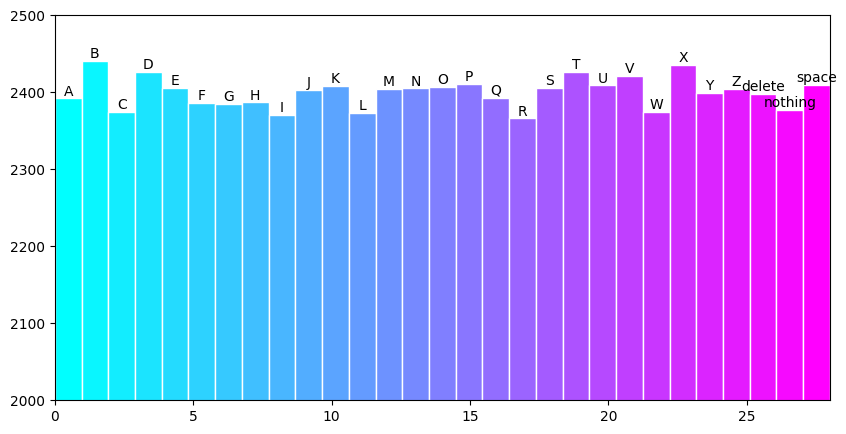

In [10]:
viz.distPlot(y_train, labels)

In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [12]:
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1))
X_test_scaled = scaler.transform(X_test.reshape(X_test.shape[0], -1))
X_val_scaled = scaler.transform(X_val.reshape(X_test.shape[0], -1))

In [13]:
# Apply PCA
pca = PCA(n_components=0.95)  # Keep 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
X_val_pca = pca.transform(X_val_scaled)

In [14]:
np.save('/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/X_train_pca.npy', X_train_pca)
np.save('/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/X_test_pca.npy', X_test_pca)
np.save('/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/X_val_pca.npy', X_val_pca)

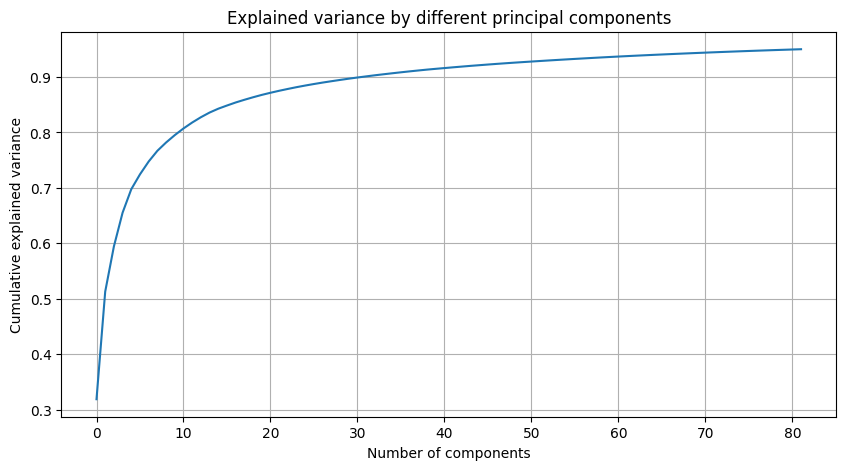

In [15]:
# Explained variance plot
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Explained variance by different principal components')
plt.grid(True)
plt.show()

In [27]:
mapping = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: 'del', 27: 'nothing', 28: 'space'}
classes = np.unique(y_train)

class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {classes[i]: class_weights[i] for i in range(len(classes))}

weight_path = 'keras_pre-trained_models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
# weight_path2 = 'keras_pre-trained_models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pretrained = VGG16(weights = weight_path, include_top=False, input_shape=(imageSize, imageSize, 3))
# pretrained_model_2 = InceptionV3(weights = weight_path2, include_top=False, input_shape=(imageSize, imageSize, 3))
optimizer1 = keras.optimizers.Adam()
# optimizer2 = keras.optimizers.RMSprop(lr=0.0001)

In [28]:
class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

In [29]:
importlib.reload(fit)

<module 'fit' from '/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/CMSE 890 Project/fit.py'>

In [17]:
history1, model1 = fit.scaled1dNetwork(X_train_pca, y_trainHot, X_val_pca, y_valHot,class_weight_dict,30,20,optimizer1)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 82)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        42,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 30)             │         7,710 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 181,534 (709.12 KB)

 Trainable params: 181,534 (709.12 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.1802 - loss: 6.1140 - val_accuracy: 0.5811 - val_loss: 1.9718
Epoch 2/20
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.4692 - loss: 2.2129 - val_accuracy: 0.6818 - val_loss: 1.6949
Epoch 3/20
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5406 - loss: 2.0267 - val_accuracy: 0.7432 - val_loss: 1.5639
Epoch 4/20
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5807 - loss: 1.9363 - val_accuracy: 0.7420 - val_loss: 1.5160
Epoch 5/20
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5981 - loss: 1.8924 - val_accuracy: 0.7691 - val_loss: 1.5082
Epoch 6/20
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6102 - loss: 1.8640 - val_accuracy: 0.7841 - val_loss: 1.4712
Epoch 7/20
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6227 - loss: 1.8329 - val_accuracy: 0.7872 - val_loss: 1.4445
Epoch 8/20
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6258 - loss: 1.8278 - 

In [16]:
history, model = fit.pretrainedNetwork(X_train, y_trainHot, X_val, y_valHot,pretrained,weight_path,class_weight_dict,30,10,optimizer1)

NameError: name 'pretrained' is not defined

In [18]:
model1.save('assets/models/ASL_DNN_1D.keras')
model1.save("assets/models/ASL_DNN_1D.h5")

In [31]:
model.save('assets/models/ASL_DNN_3D.keras')
model.save("assets/models/ASL_DNN_3D.h5")

In [19]:
len(mapping.values())

29

In [20]:
model1.predict(np.expand_dims(X_val_pca[0], axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


array([[1.8918309e-01, 2.7803553e-02, 1.5895387e-02, 7.4706316e-02,
        4.7010578e-02, 6.2091108e-03, 9.9353258e-08, 2.6203716e-11,
        1.1164176e-07, 4.8402948e-10, 6.1635941e-09, 9.3725741e-02,
        1.7977236e-01, 2.5962244e-03, 9.9831954e-02, 6.0407142e-09,
        5.4994302e-09, 1.2446958e-06, 1.7766494e-02, 2.2174877e-01,
        1.3839697e-02, 1.2708022e-03, 5.2823625e-03, 2.6962394e-05,
        1.0844810e-04, 3.2140645e-03, 5.7824881e-08, 2.3983766e-06,
        4.1722728e-06, 3.4428531e-17]], dtype=float32)

In [21]:
from sklearn.metrics import accuracy_score

# Predict the classes for the 1D test set
y_pred1DHot = model1.predict(X_test_pca)

# If the predictions are probabilities (as with some models), 
# you'll need to convert to predicted class labels by taking the argmax
if y_pred1DHot.ndim > 1:
    y_pred1D = np.argmax(y_pred1DHot, axis=1)

# Ensure 'y_test' is not one-hot encoded. If it is, convert it:
if y_testHot.ndim > 1:
    y_test1D = np.argmax(y_testHot, axis=1)

# Calculate the accuracy score
accuracy = accuracy_score(y_test1D, y_pred1D)

print(f"Accuracy score: {accuracy}")


544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step
Accuracy score: 0.824367816091954


In [22]:
from sklearn.metrics import classification_report
print('\n', classification_report(np.where(y_testHot > 0)[1], np.argmax(model1.predict(X_test_pca), axis=1), target_names=labels), sep='') 

  1/544 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step

544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step

              precision    recall  f1-score   support

           A       0.76      0.82      0.79       608
           B       0.87      0.81      0.84       559
           C       0.90      0.91      0.90       625
           D       0.93      0.72      0.82       574
           E       0.82      0.71      0.76       594
           F       0.82      0.80      0.81       614
           G       0.85      0.85      0.85       615
           H       0.90      0.92      0.91       613
           I       0.87      0.88      0.87       629
           J       0.92      0.85      0.88       597
           K       0.86      0.90      0.88       592
           L       0.93      0.81      0.86       627
           M       0.91      0.64      0.75       596
           N       0.82      0.93      0.87       595
           O       0.77      0.88      0.82       593
           P       0.90      0.85      0.87       589
           Q       0.86      0.98    

  1/544 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step

544/544 ━━━━━━━━━━━━━━━━━━━━ 1s 951us/step
[[499   7   7   5  21   7   0   0   0   0   0   1   3   0  20   0   0   0
    5  20   0   0   5   0   0   8   0   0   0]
 [  5 451   3   1  21   6   0   0   3   0   2   0   3   0   2   0   0   0
    0   0  12   7  40   1   0   0   1   0   1]
 [  6   3 566  13   0   4   0   0   0   0   0   2   2   0  20   0   0   0
    1   1   0   0   0   0   3   4   0   0   0]
 [ 23  17  32 416  26  15   0   0   0   0   9   2   7   0   3   0   0   0
    0  17   0   0   6   0   0   0   0   0   1]
 [ 62  17   0   2 419  20   0   0   5   0   0   2   0   0   0   0   0   0
    7   4   1   7  43   0   1   3   0   0   1]
 [ 21   9   8   4  21 494   7   0   9   0   4   0   0   0   0   0   0   0
   10   0   0   0  12   0  15   0   0   0   0]
 [  1   0   2   0   0   0 524  52   6  16   0   0   0   0   0   0   0   5
    0   0   0   0   0   0   0   0   7   0   2]
 [  0   0   0   0   0   0  23 564   0   1   0   0   0   0   0  14   8   0
    0   0   0   0   0   0   0   0   

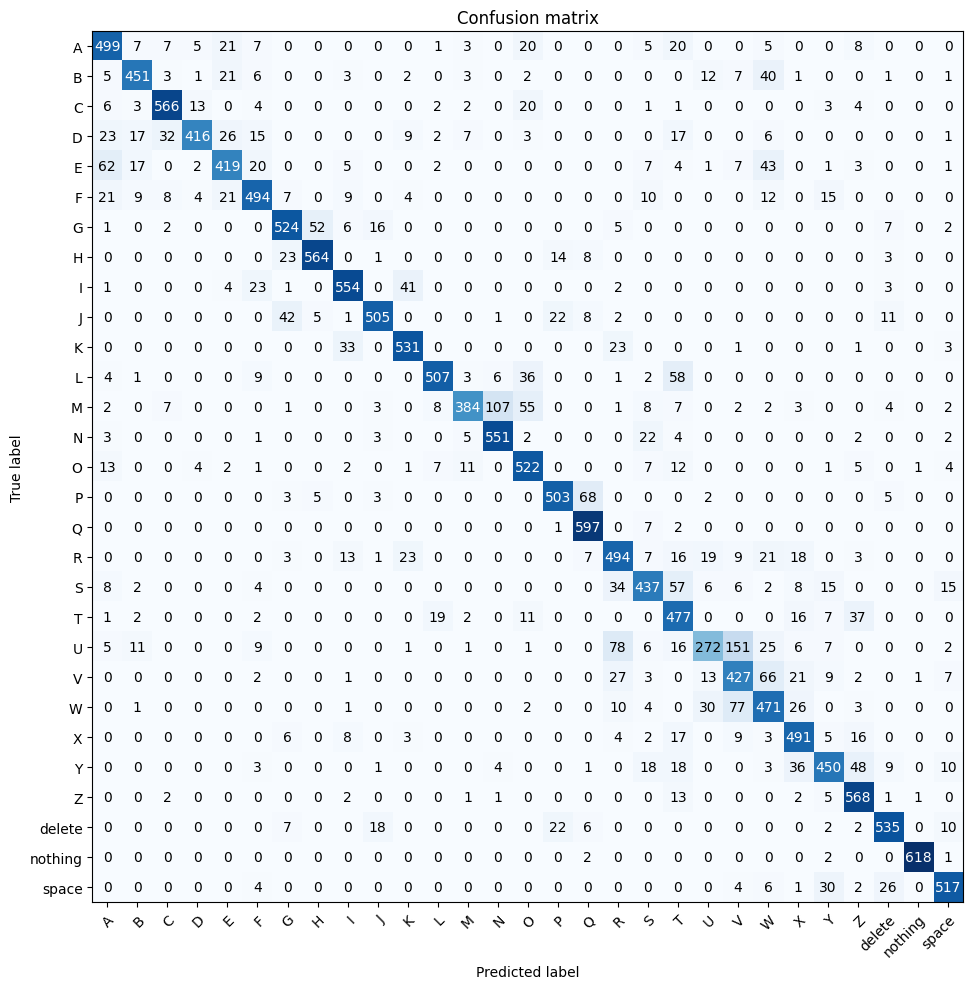

In [23]:
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    # Export to CSV
    np.savetxt('confusion_matrix.csv', cm, delimiter=',', fmt='%d')


    fig, ax = plt.subplots(1,1,figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    # ax.figure.colorbar(im, ax=ax)
    # Show all ticks and label them with the respective list entries
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Predict classes on the test set
y_pred_prob = model1.predict(X_test_pca)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_testHot, axis=1)  # Assuming ytest is one-hot encoded

# Assuming you have a list of class names as 'class_names'
plot_confusion_matrix(y_true, y_pred, classes=labels)

plt.show()

In [ ]:
# Predict the classes for the 3D test set
y_pred3D = model.predict(X_test)

# If the predictions are probabilities (as with some models), 
# you'll need to convert to predicted class labels by taking the argmax
if y_pred3D.ndim > 1:
    y_pred3D = np.argmax(y_pred3D, axis=1)

# Ensure 'y_test' is not one-hot encoded. If it is, convert it:
if y_test.ndim > 1:
    y_test3D = np.argmax(y_test, axis=1)

# Calculate the accuracy score
accuracy = accuracy_score(y_test3D, y_pred3D)

print(f"Accuracy score: {accuracy}")


In [ ]:

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred3D)

print(f"Accuracy score: {accuracy}")


In [26]:
evaluate.evaluate(model1, history1, X_test, y_testHot, mapping)

ValueError: as_list() is not defined on an unknown TensorShape.